# Plot alignment statistics of barcode-insert linkage library

## Load libraries and define analysis-specific parameters

In [2]:
suppressMessages(library(Biostrings))
suppressMessages(library(plyranges))
suppressMessages(library(tidyverse))

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


## Read alignment log

In [3]:
align_log <- list.files("../data/alignments/", pattern = "*.log", full.names = T) %>% 
  enframe("sno", "file") %>% 
  filter(str_detect(file, "endo12k")) %>% 
  mutate(log = map(file, readLines)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.bowtie2align.log)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  print()

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(log)`”


# A tibble: 7 × 2
  log                                                              sample_name
  <chr>                                                            <chr>      
1 "20192746 reads; of these:"                                      endo12k    
2 "  20192746 (100.00%) were unpaired; of these:"                  endo12k    
3 "    2799195 (13.86%) aligned 0 times"                           endo12k    
4 "    16977903 (84.08%) aligned exactly 1 time"                   endo12k    
5 "    415648 (2.06%) aligned >1 times"                            endo12k    
6 "86.14% overall alignment rate"                                  endo12k    
7 "[bam_sort_core] merging from 4 files and 4 in-memory blocks..." NA         


## How many total reads and reads with expected barcodes?


── Column specification ────────────────────────────────────────────────────────
cols(
  sample_name = col_character(),
  type = col_character(),
  count = col_double()
)



# A tibble: 3 × 4
  sample_name read  type      count
  <chr>       <chr> <chr>     <dbl>
1 endo12k     total all    20192746
2 endo12k     aln   unique 16977903
3 endo12k     aln   multi    415648


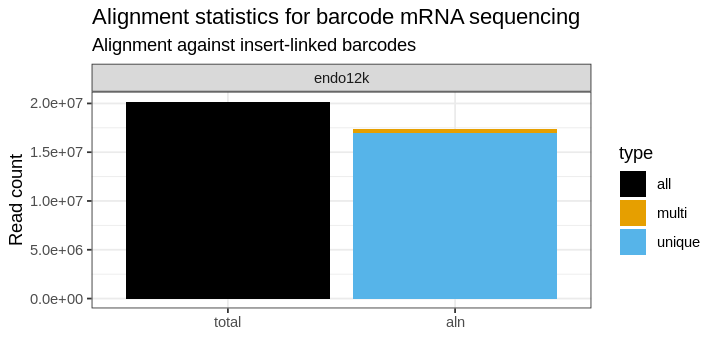

In [4]:
options(repr.plot.width=6, repr.plot.height=3)

plot_data <- align_log %>% 
  mutate(total_all = str_extract(log, "^[:digit:]+(?= reads;)")) %>% 
  mutate(aln_unique = str_extract(log, "[:digit:]+(?=.+exactly)")) %>% 
  mutate(aln_multi = str_extract(log, "[:digit:]+(?=.+>1)")) %>% 
  select(-log) %>% 
  pivot_longer(-sample_name, names_to = 'type', values_to = 'count') %>% 
  filter(!is.na(count)) %>% 
  type_convert() %>% 
  separate(type, c("read", "type")) %>% 
  print()

plot_data %>% 
  ggplot(aes(x = fct_rev(read), y = count, fill = type)) +
  facet_wrap(~sample_name, ncol = 2, scales = "free_x") +
  geom_col() +
  ggthemes::scale_fill_colorblind() +
  theme_bw() +
  labs(x = "", y = "Read count",
       title = "Alignment statistics for barcode mRNA sequencing",
       subtitle = "Alignment against insert-linked barcodes")

## Get insert-barcode linkages with counts

In [5]:
insert_barcode_linkages <- list.files("../data/filtered_barcodes//", 
                                      pattern = ".tsv.gz$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_tsv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.tsv.gz)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  select(-barcode_1) %>%
  print()

Rows: 704011 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): barcode_1
dbl (3): insert_num, barcode_num, read_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(counts)`”


# A tibble: 704,011 × 4
   insert_num barcode_num read_count sample_name
        <dbl>       <dbl>      <dbl> <chr>      
 1        594           1        358 endo12k    
 2      10779           2        263 endo12k    
 3      10521           3        263 endo12k    
 4        663           4        261 endo12k    
 5       7477           5        245 endo12k    
 6       7269           6        237 endo12k    
 7       7052           7        230 endo12k    
 8       8309           8        228 endo12k    
 9       5792           9        227 endo12k    
10       9573          10        225 endo12k    
# … with 704,001 more rows


## Get sample annotations


In [7]:

sample_annotations <- read_csv("../annotations/sample_annotations.csv", comment = "#") %>% print()

Rows: 1 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): owner, sample_name, plasmid, library_type, sample_id
dbl (6): insert_read, trim5, trim3, barcode1_read, barcode1_start, barcode1_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 1 × 11
  owner sample_name plasmid  library_type sample_id insert_read trim5 trim3
  <chr> <chr>       <chr>    <chr>        <chr>           <dbl> <dbl> <dbl>
1 pb    endo12k     pPBHS286 plasmid      139p7               1    48    28
# … with 3 more variables: barcode1_read <dbl>, barcode1_start <dbl>,
#   barcode1_length <dbl>


# Plot CDF of the number of reads per barcode

# A tibble: 704,011 × 5
   insert_num barcode_num read_count sample_name xaxis
        <dbl>       <dbl>      <dbl> <chr>       <int>
 1        594           1        358 endo12k         1
 2      10779           2        263 endo12k         2
 3      10521           3        263 endo12k         3
 4        663           4        261 endo12k         4
 5       7477           5        245 endo12k         5
 6       7269           6        237 endo12k         6
 7       7052           7        230 endo12k         7
 8       8309           8        228 endo12k         8
 9       5792           9        227 endo12k         9
10       9573          10        225 endo12k        10
# … with 704,001 more rows


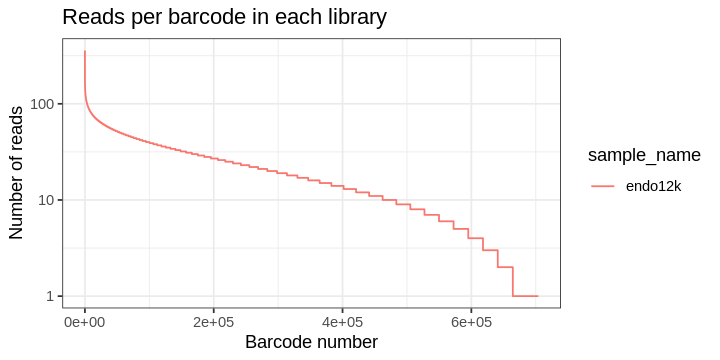

In [9]:
options(repr.plot.width=6, repr.plot.height=3)

plot_data <- insert_barcode_linkages %>% 
  group_by(sample_name) %>% 
  arrange(-read_count) %>% 
  mutate(xaxis = 1:(dplyr::n())) %>% 
  ungroup() %>% 
  print()

plot_data %>% 
  ggplot(aes(x = xaxis, y = read_count, color = sample_name)) +
  geom_line(aes(group = sample_name)) +
  theme_bw() +
  scale_y_log10() +
  labs(x = "Barcode number", y = "Number of reads",
       title = "Reads per barcode in each library") +
  NULL

## Plot CDF of the number of reads per insert, summed over barcodes


`summarise()` has grouped output by 'sample_name'. You can override using the `.groups` argument.


# A tibble: 11,987 × 4
   sample_name insert_num read_count xaxis
   <chr>            <dbl>      <dbl> <int>
 1 endo12k           5600       5048     1
 2 endo12k           5578       4921     2
 3 endo12k          10889       4431     3
 4 endo12k           5843       4116     4
 5 endo12k          10890       4069     5
 6 endo12k           5807       4065     6
 7 endo12k           5679       3852     7
 8 endo12k           8649       3845     8
 9 endo12k           5972       3837     9
10 endo12k           5896       3771    10
# … with 11,977 more rows


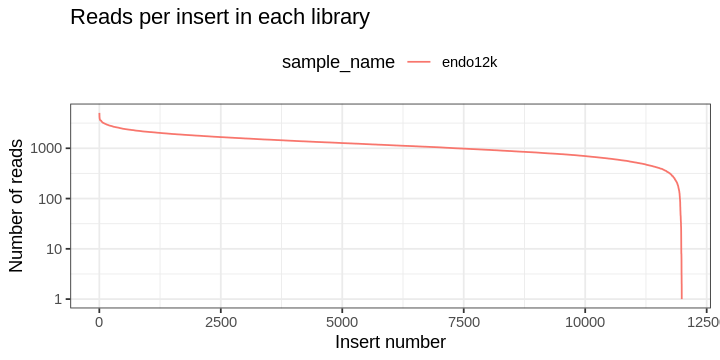

In [11]:
options(repr.plot.width=6, repr.plot.height=3)

plot_data <- insert_barcode_linkages %>% 
  group_by(sample_name, insert_num) %>% 
  summarize(read_count = sum(read_count)) %>% 
  ungroup() %>% 
  group_by(sample_name) %>% 
  arrange(-read_count) %>% 
  mutate(xaxis = 1:(dplyr::n())) %>% 
  ungroup() %>% 
  print()

plot_data %>% 
  ggplot(aes(x = xaxis, y = read_count, color = sample_name)) +
  geom_line(aes(group = sample_name)) +
  theme_bw() +
  theme(legend.position = "top") +
  scale_y_log10() +
  labs(x = "Insert number", y = "Number of reads",
       title = "Reads per insert in each library") +
  NULL